# Paper Plots

In [1]:
# This notebook contains the code for making the plots in the offline analysis paper

In [1]:
#Import same packages as AN_plots
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
from hist import Hist
import pickle
import mplhep as hep
import math
from tabulate import tabulate
import itertools
import warnings
import scipy
from plot_utils import *
import fill_utils
import uproot

warnings.filterwarnings('ignore')
hep.style.use("CMS")
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams['figure.facecolor'] = 'white'

In [2]:
# sourceDir = '/work/submit/{}/SUEP/outputs/'.format('pvanstee')
# infile_names = glob.glob(sourceDir+'*.pkl') # Read in the pkl files

# filenames_offline_data = [f for f in infile_names if ("combined_data_november_v2." in f) and ('JetHT' in f)] # Only take the correct datafiles with the correct tag

# plots = loader(filenames_offline_data, exclude_low_bins=True,auto_lumi = True)['data'] # Get dictionary with histograms 

# # for f in filenames_offline_data:
# #     print(f)

In [3]:
## parameters
output_label = '/home/submit/{}/public_html/SUEP/analysis/debug/'.format(os.environ['USER'])
file_ext = '.png'
outFile = 'data.root'

In [4]:
# create output dir
if not os.path.isdir(output_label): 
    print("Creating", output_label)
    os.mkdir(output_label)

# This part is meant to be flxeible, depending on what you want to import
# dimensions of plots: (sample) x (plot label)
# N.B.: lumis are applied through loader()

# input .pkl files
plotDir = '/data/submit/{}/SUEP/outputs/'.format(os.environ['USER'])
infile_names = glob.glob(plotDir+'*.pkl') 


# generate list of files that you want to merge histograms for
# offline_files_SUEP = [f for f in infile_names if ( "2016apv_private_v0_correct.pkl" in f and 'generic' in f and 'GluGlu' in f and 'mS125' in f ) ]
offline_files_2018 = [f for f in infile_names if "unblind.pkl" in f and ('Run2018' in f or '20UL18' in f)]
offline_files_2017 = [f for f in infile_names if "unblind.pkl" in f and ('Run2017' in f or '20UL17' in f)]
offline_files_2016 = [f for f in infile_names if "unblind.pkl" in f and ('Run2016' in f or '20UL16' in f) and 'HIPM' in f]
offline_files_2016apv = [f for f in infile_names if "unblind.pkl" in f and ('Run2016' in f or '20UL16' in f) and not 'HIPM' in f]


all_files = offline_files_2018+offline_files_2017+offline_files_2016+offline_files_2016apv

plots_2018 = loader(offline_files_2018, auto_lumi=True, exclude_low_bins=True)
plots_2017 = loader(offline_files_2017, auto_lumi=True, exclude_low_bins=True)
plots_2016 = loader(offline_files_2016, auto_lumi=True, exclude_low_bins=True)
plots_2016apv = loader(offline_files_2016apv, auto_lumi=True, exclude_low_bins=True)

plots_all = loader(offline_files_2018, auto_lumi=True, exclude_low_bins=True)
plots = plots_all['data']

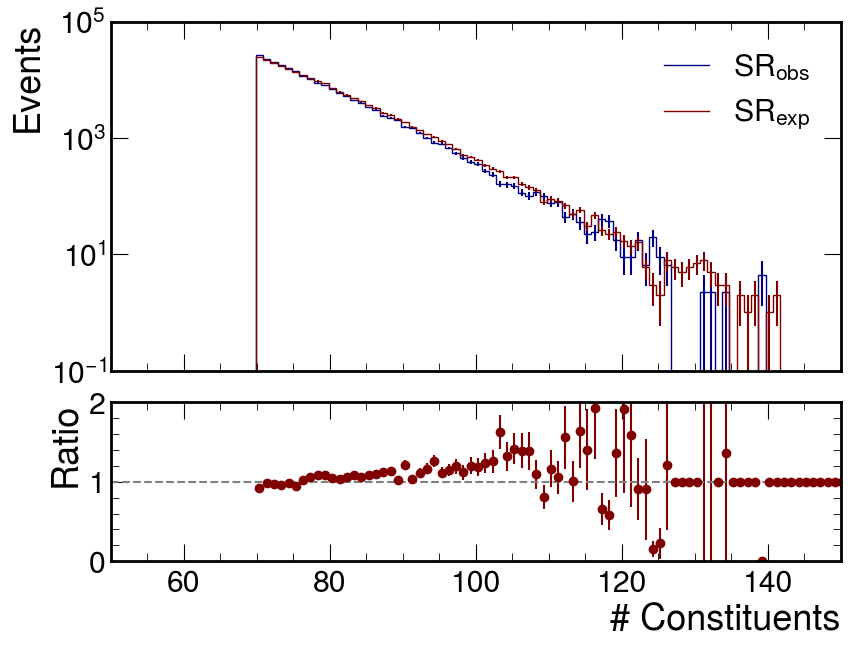

In [5]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster70'
abcd = plots[plot_label][::,::] 


# 2D_SUEP_S1_vs_SUEP_nconst_Cluster
# 2D_ISR_S1_vs_ISR_nconst_ClusterInverted
xregions = [0.3j, 0.4j, 0.5j, 1.0j]
yregions = [30j, 50j, 70j, 300j]

SR, SR_exp = ABCD_9regions_errorProp(abcd, xregions, yregions, sum_var='x')

nonzero = (SR.values() > 0) | (SR_exp.values() > 0) # don't consider empty bins for KS test

fig, axs = plot_ratio([SR_exp, SR], labels=["$SR_{obs}$", "$SR_{exp}$"])
_ = axs[1].set_ylim(0.,2)
_ = axs[0].set_ylim(1.0e-1,1.0e5)
_ = axs[1].set_xlim(50, 150)
_ = axs[0].legend()
exp_counts = SR_exp.values()[nonzero][0]+SR_exp.values()[nonzero][1]
obs_counts = SR.values()[nonzero][0]+SR_exp.values()[nonzero][1]

plt.show()

## ABCD region distribution plot

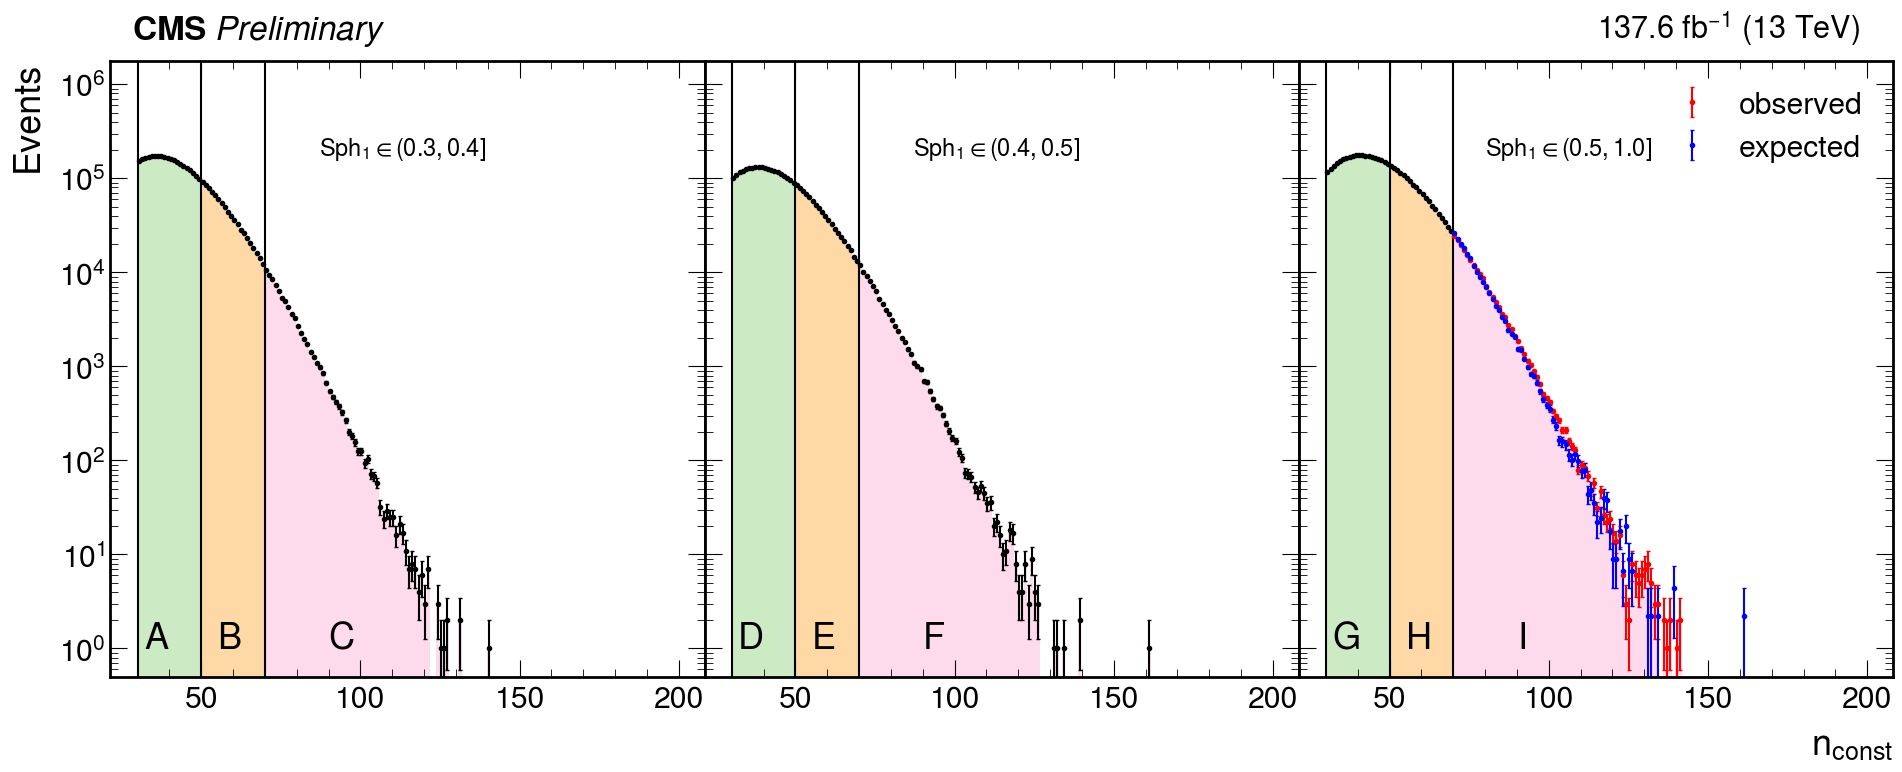

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(23, 8), sharey=True,sharex=True) #Plot 3 subplots
fig.subplots_adjust(wspace=0) #Plot 
(ax1, ax2, ax3) = axes

h = plots['A_SUEP_nconst_Cluster70']

slicing = [30,50,70,200] #The boundary of the ABCD regions 
label_positions = [32,55,90] #The positions of the letters
colormap = plt.cm.get_cmap('Pastel1')
colors = [colormap(0.3),colormap(0.5),colormap(0.8)]
# colors = [colormap(0.2),colormap(0.4),colormap(0.6)]

ymax = 0

# Plot the distributions in every region
regions = {'A':(ax1,0),
           'B':(ax1,1),
           'C':(ax1,2),
           'D':(ax2,0),
           'E':(ax2,1),
           'F':(ax2,2),
           'G':(ax3,0),
           'H':(ax3,1),
           'I':(ax3,2)}

with uproot.recreate(outFile) as froot:
    for letter, (axis,i) in regions.items():

        h = plots[letter + '_SUEP_nconst_Cluster70']
        h = h[slicing[i]*1j:slicing[i+1]*1j]

        if letter == 'I':
            froot['SR_SUEP_nconst'] = h
        else:
            froot[letter + '_SUEP_nconst'] = h
        
        yerr = h.variances()**0.5 #Take error
        y, x = h.to_numpy()
        axis.stairs(y,x,fill=True,color=colors[i])
        
        centers = (x + np.roll(x,1))/2
        centers = centers[1:] #centers of bins
        axis.text(label_positions[i],1,str(letter))
        if letter == 'I': continue
        axis.errorbar(centers,y,yerr=yerr,linestyle='',c='black',capsize=1.5,fmt ='.')
        ymax = max(np.append(y,ymax))

    froot['SR_exp_SUEP_const'] = SR_exp[70j:slicing[-1]*1.j]

ax3.errorbar(centers,y,yerr=yerr,linestyle='',c='red',capsize=1.5,fmt ='.',label='observed')
ax3.errorbar(centers,SR_exp[70j:slicing[-1]*1.j].values(),yerr=SR_exp[70j:slicing[-1]*1.j].variances()**0.5,linestyle='',c='blue',capsize=1.5,fmt ='.',label ='expected')

ytop = ymax *10 # The upper limit for the yaxis

#Adjust the figure and add labels 
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(0.5,ytop)
    ax.vlines([30,50,70],0.5,ytop,color='black') #Take bin edges
    

ax1.set_ylabel('Events',labelpad=10)
ax3.set_xlabel('$n_{const}$', labelpad=10, loc='right')

ax1.text(87,ymax,r'$Sph_{1} \in (0.3,0.4]$',fontsize=17)
ax2.text(87,ymax,r'$Sph_{1} \in (0.4,0.5]$',fontsize=17)
ax3.text(80,ymax,r'$Sph_{1} \in (0.5,1.0]$',fontsize=17)

# ax3.set_xlim([10,220])
plt.legend()

#Add CMS statements
cms = ax.text(
    -345, ytop*1.7, u"CMS $\it{Preliminary}$",
    fontsize=24, fontweight='bold',
)

lumi = ax.text(
    115, ytop*1.7, r"%.1f fb$^{-1}$ ($13$ TeV)" % round(lumiLabel('2016')+lumiLabel('2017')+lumiLabel('2018'),1),
    fontsize=22,
)
fig.tight_layout()
plt.autoscale()

plt.savefig('/home/submit/{}/test/EXO-23-002/images/all_regions.pdf'.format(os.environ['USER']),format='pdf',bbox_inches='tight')